# MovieLens

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse

import time

## load data

In [2]:
dRatings = pd.read_csv("data/data.txt", sep="\t", header=None,
                   names=["user", "movie", "rating"])
movies_raw = pd.read_csv("data/movies.txt", sep="\t", header=None, index_col=0,
                     names=["movie","title","unknown","action","adventure","animation",
                            "childrens", "comedy","crime","documentary","drama",
                            "fantasy", "filmnoir", "horror","musical","mystery",
                            "romance","scifi","thriller","war","western"]
                    ).sort_index()

dUsers = pd.DataFrame(index=pd.Index(dRatings["user"].unique(), name="user")).sort_index()
dMovies = movies_raw.loc[:,["title"]]
dGenres = movies_raw.iloc[:,1:]

nUsers = dUsers.shape[0]
nRatings = dRatings.shape[0]
nMovies = dMovies.shape[0]
nGenres = dGenres.shape[1]

and comptue some useful stuff

In [146]:
spRatings = scipy.sparse.csr_matrix(
    (dRatings["rating"], (dRatings["user"]-1, dRatings["movie"]-1))
)
dsRatings = pd.DataFrame.sparse.from_spmatrix(
    spRatings, index=dUsers.index, columns=dMovies.index
).astype(pd.SparseDtype("float", np.nan))
spRated = spRatings > 0

In [4]:
def mtoa(mat):
    return np.array(mat).flatten()

dUsers = dUsers.assign(watched=mtoa(spRated.sum(axis=1)))
dUsers = dUsers.assign(rateravg=mtoa(spRatings.sum(axis=1))/dUsers["watched"])

dMovies = dMovies.assign(ratings=mtoa(spRated.sum(axis=0)))
dMovies = dMovies.assign(movieavg=mtoa(spRatings.sum(axis=0))/dMovies["ratings"])

## screw around with data

### Fun with movies

In [156]:
def ratinghist(ratings, **kwargs):
    """histogram with bins from 1 to 5"""
    return plt.hist(ratings, bins=range(1,7))

def getRatings(df):
    """returns ratings (non-nan) values"""
    values = df.values.flatten()
    return values[~np.isnan(values)]

(array([ 6110., 11370., 27145., 34174., 21201.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

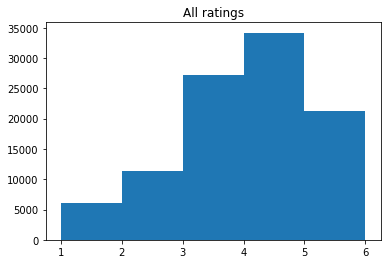

In [158]:
plt.title("All ratings")
ratinghist(getRatings(dsRatings))

(array([1.146e+03, 2.490e+02, 1.390e+02, 6.700e+01, 3.800e+01, 2.400e+01,
        7.000e+00, 5.000e+00, 6.000e+00, 1.000e+00]),
 array([  1. ,  59.2, 117.4, 175.6, 233.8, 292. , 350.2, 408.4, 466.6,
        524.8, 583. ]),
 <a list of 10 Patch objects>)

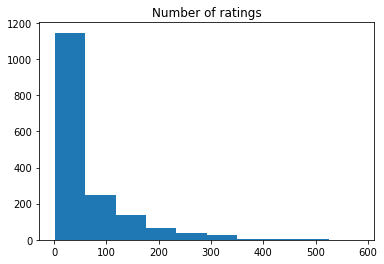

In [94]:
plt.title("Number of ratings")
plt.hist(dMovies["ratings"])

,title,ratings,movieavg
movie,,,
1536,Aiqing wansui (1994),1,5.0
1500,Santa with Muscles (1996),2,5.0
1189,Prefontaine (1997),3,5.0
1201,Marlene Dietrich: Shadow and Light (1996),1,5.0
1599,Someone Else's America (1995),1,5.0
1122,They Made Me a Criminal (1939),1,5.0
814,"Great Day in Harlem, A (1994)",1,5.0
1653,Entertaining Angels: The Dorothy Day Story (1996),1,5.0
1467,"Saint of Fort Washington, The (1993)",2,5.0


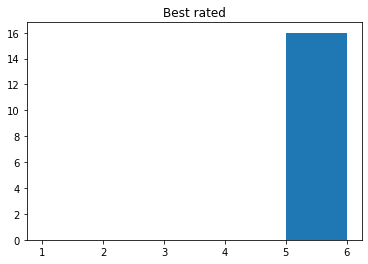

In [159]:
plt.title("Best rated")
best = dMovies.sort_values("movieavg").tail(10)
ratinghist(getRatings(dsRatings[best.index]))
best

,title,ratings,movieavg
movie,,,
121,Independence Day (ID4) (1996),429,3.438228
300,Air Force One (1997),431,3.631090
1,Toy Story (1995),452,3.878319
288,Scream (1996),478,3.441423
286,"English Patient, The (1996)",481,3.656965
294,Liar Liar (1997),485,3.156701
181,Return of the Jedi (1983),507,4.007890
100,Fargo (1996),508,4.155512
258,Contact (1997),509,3.803536


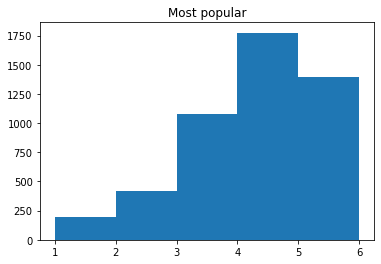

In [160]:
plt.title("Most popular")
popular = dMovies.sort_values("ratings").tail(10)
ratinghist(getRatings(dsRatings[popular.index]))
popular

(array([ 942., 2017., 5061., 6882., 4559.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

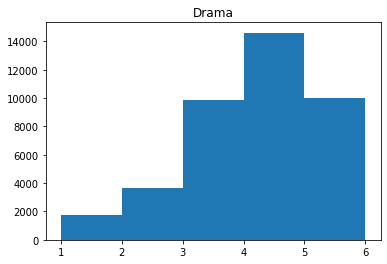

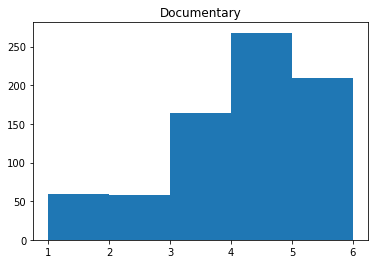

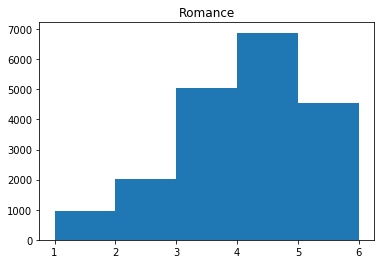

In [161]:
def genreRatings(genre):
    movies = dMovies.loc[dGenres[genre]==1,:].index
    return ratinghist(getRatings(dsRatings[movies]))
plt.title("Drama")
genreRatings("drama")
plt.figure()
plt.title("Documentary")
genreRatings("documentary")
plt.figure()
plt.title("Romance")
genreRatings("romance")

### fun with users

(array([  4.,  10.,  23.,  97., 385.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

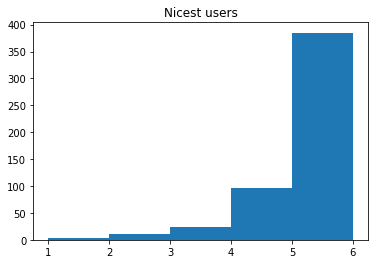

In [164]:
plt.title("Nicest users")
nice = dUsers.sort_values("rateravg").tail(10).index
ratinghist(getRatings(dsRatings.loc[nice,:]))

(array([1073.,  311.,  192.,  134.,  116.]),
 array([1, 2, 3, 4, 5, 6]),
 <a list of 5 Patch objects>)

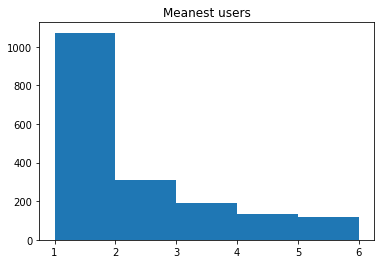

In [165]:
plt.title("Meanest users")
mean = dUsers.sort_values("rateravg").head(10).index
ratinghist(getRatings(dsRatings.loc[mean,:]))

### fun with genres

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text xticklabel objects>)

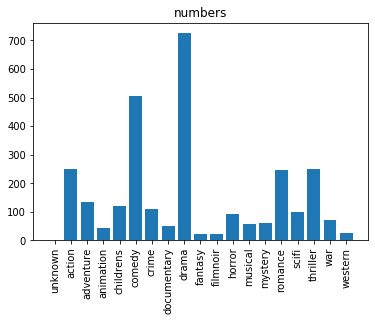

In [123]:
plt.title("numbers")
plt.xticks(rotation=90)
plt.bar(dGenres.columns, dGenres.sum(axis=0))

<BarContainer object of 19 artists>

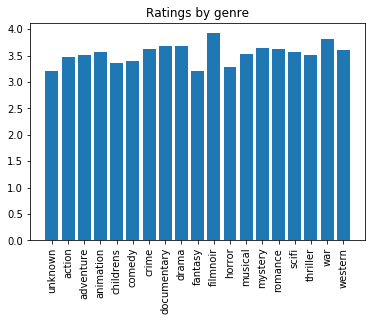

In [167]:
genreavg = np.zeros(nGenres)
for i in range(nGenres):
    movies = dMovies.index[dGenres.iloc[:,i]==1]
    genreavg[i] = spRatings[:,movies-1].data.mean()

plt.title("Ratings by genre")
plt.xticks(rotation=90)
plt.bar(dGenres.columns, genreavg)

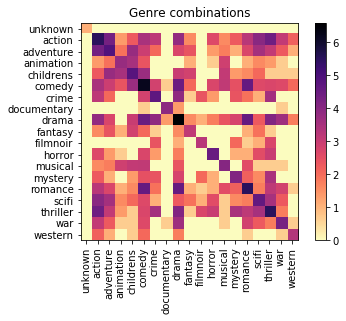

In [168]:
combos = np.zeros((nGenres, nGenres))
for i in range(nGenres):
    combos[i] = dGenres.loc[dGenres.iloc[:,i]==1].sum(axis=0)

plt.title("Genre combinations")
plt.imshow(np.log1p(combos), cmap="magma_r")
plt.yticks(ticks=range(nGenres), labels=dGenres.columns)
plt.xticks(ticks=range(nGenres), labels=dGenres.columns, rotation=90)
plt.colorbar()

There is an unfortunate lack of comedy film-noir, children's horror, and variety in documentaries.
I mean, who doesn't want a scifi documentary, or a comedy documentary...

Though we do have a war musical (Pink Floyd - The Wall (1982)), fantasy crime (Mask, The (1994)), and dramas about everything.

In [178]:
combo = ["fantasy","crime"]
dMovies[(dGenres[combo].sum(axis=1) == len(combo))]

,title,ratings,movieavg
movie,,,
72,"Mask, The (1994)",129,3.193798
